# Random Forest Model - HDB Resale Price Prediction

This notebook implements a Random Forest model to predict Singapore HDB resale prices.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from util.preprocess import preprocess as test_preprocess
import util.geo_data as geo
from importlib import reload
reload(geo)
import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading and Initial Analysis


In [ ]:
# Load raw train and test data (unified preprocessing + geo features)
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("\nTrain columns:")
print(df_train.columns.tolist())


训练数据形状: (162691, 11)
测试数据形状: (50000, 10)

训练数据列名:
['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET', 'FLOOR_RANGE', 'FLOOR_AREA_SQM', 'FLAT_MODEL', 'ECO_CATEGORY', 'LEASE_COMMENCE_DATA', 'RESALE_PRICE']


In [ ]:
# Inspect basic data info
print("Train info:")
print(df_train.info())
print("\nTrain head:")
print(df_train.head())


训练数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MONTH                162691 non-null  object 
 1   TOWN                 162691 non-null  object 
 2   FLAT_TYPE            162691 non-null  object 
 3   BLOCK                162691 non-null  object 
 4   STREET               162691 non-null  object 
 5   FLOOR_RANGE          162691 non-null  object 
 6   FLOOR_AREA_SQM       162691 non-null  float64
 7   FLAT_MODEL           162691 non-null  object 
 8   ECO_CATEGORY         162691 non-null  object 
 9   LEASE_COMMENCE_DATA  162691 non-null  int64  
 10  RESALE_PRICE         162691 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 13.7+ MB
None

训练数据前5行:
     MONTH           TOWN FLAT_TYPE BLOCK              STREET FLOOR_RANGE  \
0  2020-10      woodlands    4 room  681B  woodlands drive 62

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

缺失值统计:
MONTH                  0
TOWN                   0
FLAT_TYPE              0
BLOCK                  0
STREET                 0
FLOOR_RANGE            0
FLOOR_AREA_SQM         0
FLAT_MODEL             0
ECO_CATEGORY           0
LEASE_COMMENCE_DATA    0
RESALE_PRICE           0
dtype: int64


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

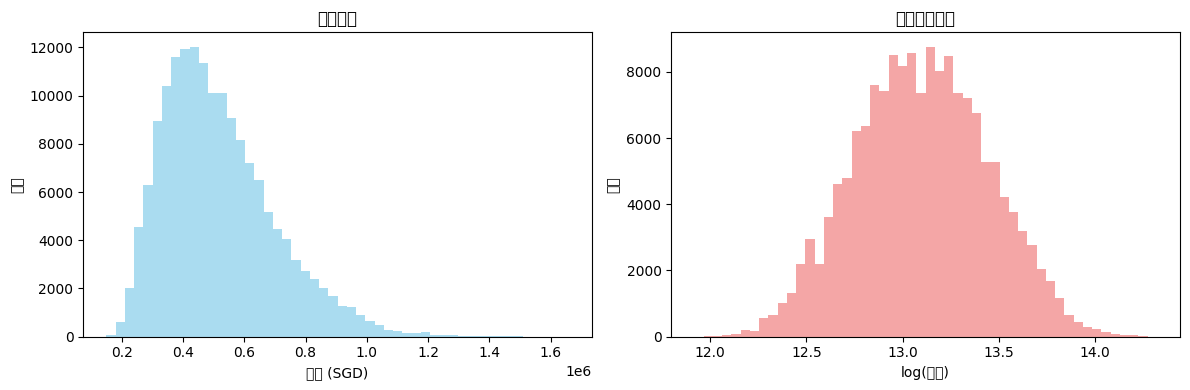

In [ ]:
# Check missing values
print("Missing values summary:")
print(df_train.isnull().sum())

# Target variable distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_train['RESALE_PRICE'], bins=50, alpha=0.7, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price (SGD)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log(df_train['RESALE_PRICE']), bins=50, alpha=0.7, color='lightcoral')
plt.title('Log Price Distribution')
plt.xlabel('log(Price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## 2. Feature Engineering and Data Preparation


In [ ]:
# Unified preprocessing for training data with geographic features
print("Start preprocessing training data...")
train_pre = test_preprocess(df_train)
print("Adding geographic features...")

# Fallback import for geo module to avoid NameError if previous cell wasn't run
if 'geo' not in globals():
    import util.geo_data as geo
    from importlib import reload
    reload(geo)

train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

# Ensure required geographic feature columns exist; if missing, print columns for debugging
required_geo_cols = [
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]
missing_cols = [c for c in required_geo_cols if c not in train_pre_geo.columns]
if missing_cols:
    print(f"[Warning] Missing geo feature columns: {missing_cols}")
    print(f"Available columns (sample): {train_pre_geo.columns.tolist()[:50]}")

# Derive AGE, YEAR, MONTH
train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

# Encode TOWN and FLAT_TYPE

town_mapping = {
    'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
    'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
    'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
    'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
    'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
    'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
}
train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)

def encode_flat_type(flat_type):
    flat_type = flat_type.lower().strip()
    if '1 room' in flat_type or '1-room' in flat_type:
        return 1
    elif '2 room' in flat_type or '2-room' in flat_type:
        return 2
    elif '3 room' in flat_type or '3-room' in flat_type:
        return 3
    elif '4 room' in flat_type or '4-room' in flat_type:
        return 4
    elif '5 room' in flat_type or '5-room' in flat_type:
        return 5
    elif 'executive' in flat_type:
        return 10
    elif 'multi generation' in flat_type:
        return 11
    else:
        return 3
train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

# Select feature columns (include geo features + school distance and density)
feature_columns = [
    'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
    'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]

X = train_pre_geo[feature_columns]
y = df_train['RESALE_PRICE']

print("Feature columns:", feature_columns)
print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)


开始预处理训练数据...
添加地理特征...
[geo] 坐标命中: 162691/162691 (100.00%), 缺失: 0
特征列: ['YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE', 'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M', 'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M', 'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M', 'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M']
特征矩阵形状: (162691, 17)
目标变量形状: (162691,)


In [ ]:
# Check feature dtypes
print("Feature dtypes:")
print(X.dtypes)

# Check for missing values
print("\nFeature missing values:")
print(X.isnull().sum())


特征数据类型:
YEAR                                    int64
MONTH                                   int64
TOWN_ENCODED                            int64
FLAT_TYPE_ENCODED                       int64
FLOOR_AVG                               int64
FLOOR_AREA_SQM                        float64
LEASE_COMMENCE_DATA                     int64
AGE                                     int64
DIST_TO_NEAREST_MRT_M                 float64
DIST_TO_NEAREST_HAWKER_M              float64
DIST_TO_NEAREST_SHOP_M                float64
DIST_TO_NEAREST_PRIMARY_SCHOOL_M      float64
DIST_TO_NEAREST_SECONDARY_SCHOOL_M    float64
NUM_PRIMARY_SCHOOLS_500M                int64
NUM_PRIMARY_SCHOOLS_1000M               int64
NUM_SECONDARY_SCHOOLS_500M              int64
NUM_SECONDARY_SCHOOLS_1000M             int64
dtype: object

特征缺失值:
YEAR                                  0
MONTH                                 0
TOWN_ENCODED                          0
FLAT_TYPE_ENCODED                     0
FLOOR_AVG                   

## 3. Random Forest Training


In [ ]:
# Split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")


训练集大小: (130152, 17)
验证集大小: (32539, 17)


In [ ]:
# Create baseline RandomForest model
rf_basic = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_basic.fit(X_train, y_train)

# Predict
y_pred_train = rf_basic.predict(X_train)
y_pred_val = rf_basic.predict(X_val)

# Evaluate metrics
print("=== Baseline Random Forest Performance ===")
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Validation R²: {r2_score(y_val, y_pred_val):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_pred_val):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_val)):.2f}")


=== 基础随机森林模型性能 ===
训练集 R²: 0.9956
验证集 R²: 0.9688
训练集 MAE: 8238.00
验证集 MAE: 21948.72
训练集 RMSE: 12178.68
验证集 RMSE: 32274.11


## 4. Hyperparameter Tuning


In [ ]:
# Define a wider parameter distribution (random search)
param_distributions = {
    'n_estimators': np.arange(200, 1201, 50),
    'max_depth': [None] + list(np.arange(8, 41, 2)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create RandomForest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized search (increase resolution/diversity; mitigate overfitting)
print("Start randomized hyperparameter search...")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=80,  # increase if you have more time
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nBest parameters:")
print(random_search.best_params_)
print(f"\nBest CV MSE: {-random_search.best_score_:.4f}")


开始随机搜索超参数...
Fitting 5 folds for each of 80 candidates, totalling 400 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0


最佳参数:
{'n_estimators': np.int64(850), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': np.int64(40), 'bootstrap': True}

最佳交叉验证分数: 1081726046.3963


In [ ]:
# Train final model with the best parameters
best_rf = random_search.best_estimator_

# Evaluate on validation set
y_pred_best = best_rf.predict(X_val)

print("=== Tuned Random Forest Performance ===")
print(f"Validation R²: {r2_score(y_val, y_pred_best):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_pred_best):.2f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_best)):.2f}")


=== 调优后的随机森林模型性能 ===
验证集 R²: 0.9701
验证集 MAE: 21863.27
验证集 RMSE: 31577.70


## 5. Feature Importance Analysis


特征重要性排序:
                               feature  importance
5                       FLOOR_AREA_SQM    0.223705
3                    FLAT_TYPE_ENCODED    0.168256
0                                 YEAR    0.145798
9             DIST_TO_NEAREST_HAWKER_M    0.089933
6                  LEASE_COMMENCE_DATA    0.089642
7                                  AGE    0.059634
4                            FLOOR_AVG    0.055504
2                         TOWN_ENCODED    0.045280
8                DIST_TO_NEAREST_MRT_M    0.027774
10              DIST_TO_NEAREST_SHOP_M    0.027571
12  DIST_TO_NEAREST_SECONDARY_SCHOOL_M    0.016498
11    DIST_TO_NEAREST_PRIMARY_SCHOOL_M    0.015003
14           NUM_PRIMARY_SCHOOLS_1000M    0.014224
16         NUM_SECONDARY_SCHOOLS_1000M    0.009328
1                                MONTH    0.004555
13            NUM_PRIMARY_SCHOOLS_500M    0.004017
15          NUM_SECONDARY_SCHOOLS_500M    0.003277


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

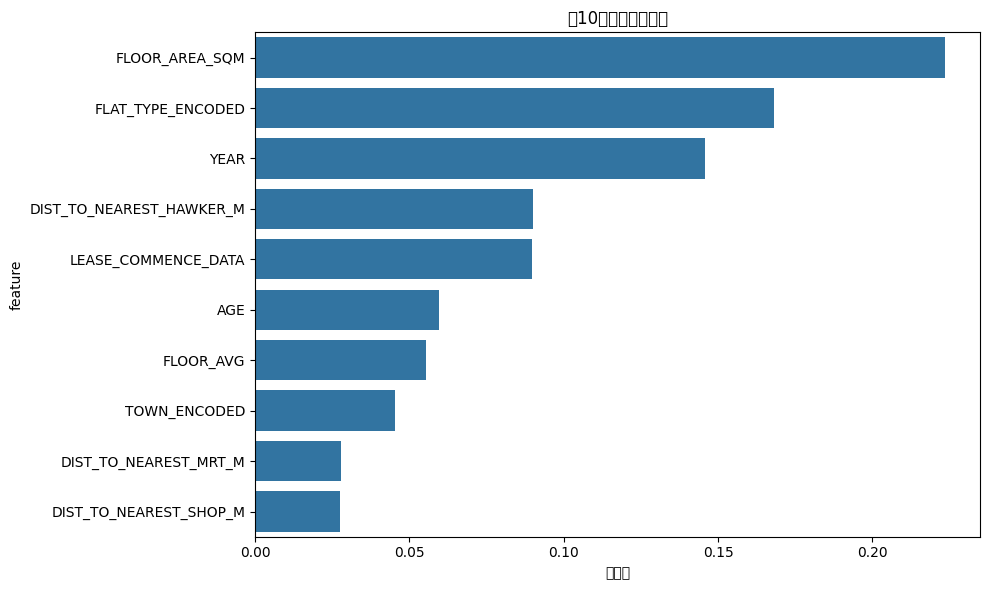

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance (sorted):")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 6. Model Performance Visualization


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

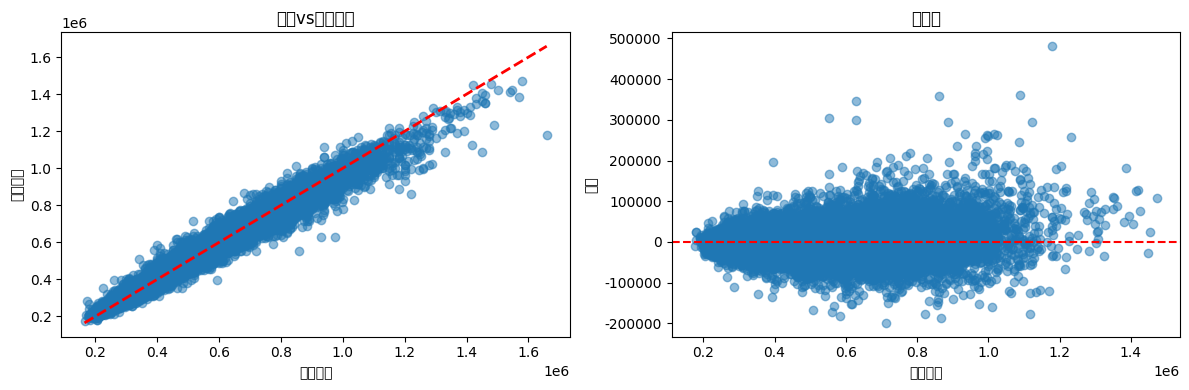

In [ ]:
# Predicted vs Actual scatter
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_val - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()


In [ ]:
# Refined search based on first tuning (build on previous results)
print("Best params from first tuning:")
print(random_search.best_params_)
print(f"First tuning CV MSE: {-random_search.best_score_:.4f}")

from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def build_refined_rf_random_search(best_params, random_state: int = 42,
                                  n_iter: int = 60,
                                  cv: int = 5,
                                  scoring: str = 'neg_mean_squared_error',
                                  n_jobs: int = -1,
                                  verbose: int = 2) -> RandomizedSearchCV:
    """Create a refined search around the best values from the first tuning."""
    param_distributions = {
        'n_estimators': randint(max(300, int(best_params['n_estimators']) - 150),
                                min(1000, int(best_params['n_estimators']) + 150)),
        'max_depth': randint(max(10, int(best_params['max_depth']) - 10),
                             min(50, int(best_params['max_depth']) + 10)),
        'min_samples_split': randint(max(2, int(best_params['min_samples_split']) - 2),
                                     min(10, int(best_params['min_samples_split']) + 3)),
        'min_samples_leaf': randint(max(1, int(best_params['min_samples_leaf']) - 1),
                                    min(5, int(best_params['min_samples_leaf']) + 2)),
        'max_features': [best_params['max_features']],
        'bootstrap': [best_params['bootstrap']],
    }

    rf = RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=random_state,
    )
    return search

print("\nStart refined search (based on first tuning)...")
refined_search = build_refined_rf_random_search(
    random_search.best_params_,
    random_state=42,
    n_iter=60,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
)
refined_search.fit(X_train, y_train)

print("\nBest parameters from refined search:")
print(refined_search.best_params_)
print(f"Best CV MSE from refined search: {-refined_search.best_score_:.4f}")

print(f"\n=== Tuning Results Comparison ===")
print(f"First tuning CV MSE: {-random_search.best_score_:.4f}")
print(f"Refined search CV MSE: {-refined_search.best_score_:.4f}")
improvement = random_search.best_score_ - refined_search.best_score_
print(f"Improvement: {improvement:.4f}")

final_best_params = refined_search.best_params_



第一次调优的最佳参数:
{'n_estimators': np.int64(850), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': 'log2', 'max_depth': np.int64(40), 'bootstrap': True}
第一次调优CV MSE: 1081726046.3963

开始精细搜索（基于第一次调优结果）...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 2.9min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 2.9min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 3.1min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=806; total time= 3.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 3.4min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 3.5min
[CV] END bootstrap=True, max_depth=37, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=787; total time= 2.5min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=787; total time= 2.5min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=787; total time= 2.6min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=787; total time= 2.6min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 3.3min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=802; total time= 3.2min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=957; total time= 3.1min
[CV] END bootstrap=True, max_depth=33, max_featu

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.15s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=891; total time= 3.0min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=891; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=891; total time= 2.9min


0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=891; total time= 2.9min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=952; total time= 3.2min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=952; total time= 3.2min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=952; total time= 3.3min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=758; total time= 3.1min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=952; total time= 3.3min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=952; total time= 3.3min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=758; total time= 3.1min
[CV] END bootstrap=True, max_depth=41, max_featu

0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.01s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=874; total time= 3.0min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=874; total time= 3.0min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=874; total time= 2.9min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=720; total time= 2.3min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=720; total time= 2.3min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=720; total time= 2.2min
[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=720; total time= 2.2min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=720; total time= 2.3min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=788; total time= 2.6min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=788; total time= 2.7min
[CV] END bootstrap=True, max_depth=38, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=964; total time= 3.7min
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=964; total time= 3.7min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=963; total time= 3.3min
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=963; total time= 3.3min
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=963; total time= 3.3min
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=964; total time= 3.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=964; total time= 3.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.13s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=963; total time= 3.0min
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=780; total time= 1.9min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=780; total time= 2.5min
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=780; total time= 2.5min


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=963; total time= 3.1min
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=780; total time= 2.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=780; total time= 2.5min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=753; total time= 2.6min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=753; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=753; total time= 2.2min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=753; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=753; total time= 2.5min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=890; total time= 3.0min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=890; total time= 3.1min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=890; total time= 3.1min
[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=890; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=890; total time= 3.1min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=901; total time= 3.1min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=901; total time= 3.2min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=901; total time= 3.1min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=901; total time= 3.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=901; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.17s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=970; total time= 3.4min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=970; total time= 3.4min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=970; total time= 3.4min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=970; total time= 3.4min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=970; total time= 3.4min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=951; total time= 3.4min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=951; total time= 3.6min
[CV] END bootstrap=True, max_depth=37, max_featu

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=714; total time= 3.2min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=714; total time= 3.2min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=714; total time= 3.1min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=714; total time= 3.1min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=714; total time= 3.1min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=708; total time= 3.0min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=708; total time= 3.0min
[CV] END bootstrap=True, max_depth=30, max_featu

0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=780; total time= 2.7min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=780; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=780; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=780; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=988; total time= 3.1min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=988; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=988; total time= 3.1min


0.06s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=988; total time= 3.1min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=740; total time= 2.5min
[CV] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=988; total time= 3.1min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=740; total time= 2.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=740; total time= 2.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=740; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=740; total time= 2.6min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=732; total time= 2.8min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=732; total time= 2.8min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=732; total time= 2.8min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=732; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=761; total time= 2.5min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=732; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=761; total time= 2.5min
[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=761; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=761; total time= 2.4min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=734; total time= 2.3min
[CV] END bootstrap=True, max_depth=45, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=761; total time= 2.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=734; total time= 2.2min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=734; total time= 2.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=734; total time= 2.2min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=734; total time= 2.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=830; total time= 2.6min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=954; total time= 3.5min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=954; total time= 3.9min
[CV] END bootstrap=True, max_depth=30, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=954; total time= 4.1min
[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=906; total time= 3.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=954; total time= 4.1min


0.06s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=906; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=43, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=906; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=878; total time= 3.0min
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=878; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=878; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=878; total time= 3.0min
[CV] END bootstrap=True, max_depth=44, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=878; total time= 3.0min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=795; total time= 3.2min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=795; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=795; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=795; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=795; total time= 3.3min
[CV] END bootstrap=True, max_depth=33, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=930; total time= 3.4min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=930; total time= 3.3min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=930; total time= 3.3min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=728; total time= 2.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=930; total time= 3.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=728; total time= 2.3min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=728; total time= 2.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=728; total time= 2.2min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=728; total time= 2.2min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=886; total time= 3.1min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=886; total time= 3.2min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=886; total time= 3.2min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=886; total time= 3.3min
[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=886; total time= 3.3min
[CV] END bootstrap=True, max_depth=48, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=869; total time= 3.1min


0.04s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.02s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=869; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=48, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=869; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=833; total time= 2.9min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=833; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=833; total time= 2.8min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=833; total time= 2.8min
[CV] END bootstrap=True, max_depth=42, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=833; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=827; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=827; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=827; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=827; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=982; total time= 3.7min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=982; total time= 3.7min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=982; total time= 3.7min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=958; total time= 4.2min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=958; total time= 4.3min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=958; total time= 4.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=836; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=836; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=958; total time= 4.0min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=958; total time= 4.1min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=836; total time= 3.1min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=836; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=836; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=933; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=933; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=933; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=933; total time= 3.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=859; total time= 2.9min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=933; total time= 3.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=859; total time= 2.8min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=859; total time= 2.9min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=859; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=859; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=751; total time= 2.8min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=751; total time= 2.8min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=751; total time= 2.9min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=751; total time= 3.0min
[CV] END bootstrap=True, max_depth=38, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=751; total time= 3.1min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=812; total time= 3.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=812; total time= 3.3min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=812; total time= 3.2min
[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=812; total time= 3.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=812; total time= 3.2min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=886; total time= 3.9min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=886; total time= 3.8min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=886; total time= 3.8min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=886; total time= 3.8min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=886; total time= 3.7min
[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=919; total time= 3.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=919; total time= 3.4min
[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=919; total time= 3.4min
[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=919; total time= 3.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=919; total time= 3.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=825; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=825; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=825; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=825; total time= 3.5min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=825; total time= 3.5min
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=859; total time= 3.5min
[CV] END bootstrap=True, max_depth=31, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=859; total time= 3.5min
[CV] END bootstrap=True, max_depth=31, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=35, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=902; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=35, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=902; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=35, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=902; total time= 2.9min


0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.01s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=35, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=902; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=979; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=979; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=979; total time= 3.0min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=979; total time= 3.0min
[CV] END bootstrap=True, max_depth=46, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=979; total time= 3.0min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=939; total time= 3.1min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=939; total time= 3.2min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=939; total time= 3.3min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=939; total time= 3.3min
[CV] END bootstrap=True, max_depth=34, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=939; total time= 3.4min
[CV] END bootstrap=True, max_depth=45, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=846; total time= 2.8min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=846; total time= 2.7min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=846; total time= 2.7min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=846; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=33, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=846; total time= 2.6min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=827; total time= 2.5min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=827; total time= 2.4min


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=827; total time= 2.5min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=827; total time= 2.5min
[CV] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=827; total time= 2.5min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=966; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=966; total time= 3.3min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=966; total time= 3.4min
[CV] END bootstrap=True, max_depth=36, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=966; total time= 3.2min
[CV] END bootstrap=True, max_depth=47, max_featu

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=997; total time= 3.3min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=997; total time= 3.1min
[CV] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=811; total time= 2.4min
[CV] END bootstrap=True, max_depth=47, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=997; total time= 3.0min
[CV] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=811; total time= 2.4min
[CV] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=811; total time= 1.9min
[CV] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=811; total time= 1.9min
[CV] END bootstrap=True, max_depth=32, max_featu

## 7. Cross-Validation Evaluation


In [ ]:
# Cross-validation with best parameters (self-contained; builds X, y if missing)
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor
import numpy as np

# If upstream cells weren't run, auto-prepare X, y
if 'X' not in globals() or 'y' not in globals():
    print("[Note] Upstream cells not detected; auto-loading data and constructing features X, y …")
    import pandas as pd
    from util.preprocess import preprocess as test_preprocess
    import util.geo_data as geo
    from importlib import reload
    reload(geo)

    # Load raw training data
    df_train = pd.read_csv('../data/train.csv')

    # Preprocess and add geo features (consistent with upstream)
    train_pre = test_preprocess(df_train)
    train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

    # Derive AGE/YEAR/MONTH
    train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
    train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
    train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

    # Encoding mappings (consistent with upstream)
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }
    def encode_flat_type(flat_type: str) -> int:
        flat_type = flat_type.lower().strip()
        if '1 room' in flat_type or '1-room' in flat_type:
            return 1
        elif '2 room' in flat_type or '2-room' in flat_type:
            return 2
        elif '3 room' in flat_type or '3-room' in flat_type:
            return 3
        elif '4 room' in flat_type or '4-room' in flat_type:
            return 4
        elif '5 room' in flat_type or '5-room' in flat_type:
            return 5
        elif 'executive' in flat_type:
            return 10
        elif 'multi generation' in flat_type:
            return 11
        else:
            return 3
    train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
    train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

    feature_columns = [
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]
    X = train_pre_geo[feature_columns]
    y = df_train['RESALE_PRICE']
    print(f"✓ Auto-built: X shape = {X.shape}, y shape = {y.shape}")
else:
    print(f"✓ Data check passed: X shape = {X.shape}, y shape = {y.shape}")

# Fixed best params
best_params_for_cv = {
    'bootstrap': True,
    'max_depth': 49,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 958,
}

# Normalize types to avoid np.* serialization issues
for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes']:
    if k in best_params_for_cv and best_params_for_cv[k] is not None:
        try:
            best_params_for_cv[k] = int(best_params_for_cv[k])
        except Exception:
            pass

print(f"Parameters for cross-validation: {best_params_for_cv}")

# Modeling: parallel inside the model; outer CV not fully parallel to reduce memory
final_rf = SKRandomForestRegressor(**best_params_for_cv, random_state=42, n_jobs=-1)

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2' : 'r2',
}

print("\nStart 5-fold cross-validation...")
cv_out = cross_validate(
    final_rf,
    X, y,
    cv=5,
    scoring=scoring,
    n_jobs=4,                # outer not fully parallel to reduce memory
    pre_dispatch='2*n_jobs'
)
print("Cross-validation completed")

# Aggregate metrics
rmse_vals = -cv_out['test_rmse']
mae_vals  = -cv_out['test_mae']
r2_vals   =  cv_out['test_r2']

rmse_mean = float(rmse_vals.mean())
rmse_ci   = float(rmse_vals.std() * 2)   # approx 95% interval
mae_mean  = float(mae_vals.mean())
mae_ci    = float(mae_vals.std() * 2)
r2_mean   = float(r2_vals.mean())
r2_ci     = float(r2_vals.std() * 2)

print("\n=== Cross-validation Results ===")
print(f"RMSE: {rmse_mean:.2f} (+/- {rmse_ci:.2f})")
print(f"MAE:  {mae_mean:.2f} (+/- {mae_ci:.2f})")
print(f"R²:   {r2_mean:.4f} (+/- {r2_ci:.4f})")

[提示] 检测到未运行前序单元，正在自动加载数据并构建特征 X、y …
[geo] 坐标命中: 162691/162691 (100.00%), 缺失: 0
✓ 已自动构建: X shape = (162691, 17), y shape = (162691,)
用于交叉验证的参数: {'bootstrap': True, 'max_depth': 49, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 958}

开始5折交叉验证...
交叉验证完成

=== 交叉验证结果 ===
RMSE: 30738.62 (+/- 312.71)
MAE:  21352.07 (+/- 151.85)
R²:   0.9719 (+/- 0.0003)


## 8. Generate Test Predictions


In [ ]:
# Generate test predictions (self-contained; rebuilds model/features if missing)
print("[Step 1] Confirm or train the final model …")

# If model or training features are missing, rebuild and train
if 'final_rf' not in globals() or 'X' not in globals() or 'y' not in globals():
    print("[Note] final_rf or X/y not found; rebuilding training set with best params and training …")
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor
    from util.preprocess import preprocess as test_preprocess
    import util.geo_data as geo
    from importlib import reload
    reload(geo)

    # Load train data and preprocess
    df_train = pd.read_csv('../data/train.csv')
    train_pre = test_preprocess(df_train)
    train_pre_geo = geo.add_geo_data(train_pre[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

    # Derive features
    train_pre_geo['YEAR'] = train_pre_geo['RESALE_YEAR']
    train_pre_geo['MONTH'] = train_pre_geo['RESALE_MONTH']
    train_pre_geo['AGE'] = train_pre_geo['YEAR'] - train_pre_geo['LEASE_COMMENCE_DATA']

    # Encoding
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }
    def encode_flat_type(flat_type: str) -> int:
        flat_type = flat_type.lower().strip()
        if '1 room' in flat_type or '1-room' in flat_type:
            return 1
        elif '2 room' in flat_type or '2-room' in flat_type:
            return 2
        elif '3 room' in flat_type or '3-room' in flat_type:
            return 3
        elif '4 room' in flat_type or '4-room' in flat_type:
            return 4
        elif '5 room' in flat_type or '5-room' in flat_type:
            return 5
        elif 'executive' in flat_type:
            return 10
        elif 'multi generation' in flat_type:
            return 11
        else:
            return 3
    train_pre_geo['TOWN_ENCODED'] = train_pre_geo['TOWN'].str.lower().map(town_mapping)
    train_pre_geo['FLAT_TYPE_ENCODED'] = train_pre_geo['FLAT_TYPE'].apply(encode_flat_type)

    feature_columns = [
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]
    X = train_pre_geo[feature_columns]
    y = df_train['RESALE_PRICE']

    # Fix best params and train
    best_params_for_cv = {
        'bootstrap': True,
        'max_depth': 49,
        'max_features': 'log2',
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 958,
    }
    final_rf = SKRandomForestRegressor(**best_params_for_cv, random_state=42, n_jobs=-1)
    final_rf.fit(X, y)
else:
    # Ensure final_rf is trained
    try:
        _ = getattr(final_rf, 'n_estimators')
    except Exception:
        from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor
        best_params_for_cv = {
            'bootstrap': True,
            'max_depth': 49,
            'max_features': 'log2',
            'min_samples_leaf': 1,
            'min_samples_split': 2,
            'n_estimators': 958,
        }
        final_rf = SKRandomForestRegressor(**best_params_for_cv, random_state=42, n_jobs=-1)
        final_rf.fit(X, y)

print("[Step 2] Preprocess test data …")
# Ensure test data and preprocess function are loaded
if 'df_test' not in globals():
    import pandas as pd
    df_test = pd.read_csv('../data/test.csv')
from util.preprocess import preprocess as test_preprocess

# Fallback import for geo module
if 'geo' not in globals():
    import util.geo_data as geo
    from importlib import reload
    reload(geo)

pre_df = test_preprocess(df_test)
pre_df_geo = geo.add_geo_data(pre_df[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())

# Ensure all required geo feature columns exist (fill missing with 0 to align with training)
required_geo_cols = [
    'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
    'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
    'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
    'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
]
missing_cols = [c for c in required_geo_cols if c not in pre_df_geo.columns]
if missing_cols:
    print(f"[Warning] Missing geo features in test; fill 0 to match training: {missing_cols}")
    for c in missing_cols:
        pre_df_geo[c] = 0.0

# Derive AGE/YEAR/MONTH (same as training)
pre_df_geo['YEAR'] = pre_df_geo['RESALE_YEAR']
pre_df_geo['MONTH'] = pre_df_geo['RESALE_MONTH']
pre_df_geo['AGE'] = pre_df_geo['YEAR'] - pre_df_geo['LEASE_COMMENCE_DATA']

# Encoding
if 'town_mapping' not in globals():
    town_mapping = {
        'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
        'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
        'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
        'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
        'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
        'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
    }

def encode_flat_type(flat_type):
    flat_type = flat_type.lower().strip()
    if '1 room' in flat_type or '1-room' in flat_type:
        return 1
    elif '2 room' in flat_type or '2-room' in flat_type:
        return 2
    elif '3 room' in flat_type or '3-room' in flat_type:
        return 3
    elif '4 room' in flat_type or '4-room' in flat_type:
        return 4
    elif '5 room' in flat_type or '5-room' in flat_type:
        return 5
    elif 'executive' in flat_type:
        return 10
    elif 'multi generation' in flat_type:
        return 11
    else:
        return 3

pre_df_geo['TOWN_ENCODED'] = pre_df_geo['TOWN'].str.lower().map(town_mapping)
pre_df_geo['FLAT_TYPE_ENCODED'] = pre_df_geo['FLAT_TYPE'].apply(encode_flat_type)

# Select feature columns; keep the exact order as training X if available
if 'X' in globals():
    feature_columns = list(X.columns)
else:
    feature_columns = [
        'YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED',
        'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE',
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]

# If test data lacks any feature, add and align order
for c in feature_columns:
    if c not in pre_df_geo.columns:
        pre_df_geo[c] = 0.0
X_test = pre_df_geo[feature_columns]

print(f"Preprocessed test shape: {X_test.shape}")
print(f"Test columns: {X_test.columns.tolist()}")
print("Test preprocessing done!")

# Quick data quality checks
print("\nTest missing values check:")
print(X_test.isnull().sum())

print("\nTest data summary:")
print(X_test.describe())

print("[Step 3] Generate predictions and export submission …")
predictions = final_rf.predict(X_test)

import pandas as pd
submission = pd.DataFrame({'id': range(len(predictions)), 'Predicted': predictions})
submission.to_csv('../result/submission_random_forest.csv', index=False)
print('Predictions saved to ../result/submission_random_forest.csv')
print(f"Num predictions: {len(predictions)}")
print(f"Predicted price range: {predictions.min():.0f} - {predictions.max():.0f}")

# Expose intermediate variables for later cells
globals()['pre_df_geo'] = pre_df_geo
globals()['X_test'] = X_test
globals()['predictions'] = predictions


[步骤1] 确认或训练最终模型 …
[步骤2] 预处理测试数据 …
[geo] 坐标命中: 50000/50000 (100.00%), 缺失: 0
预处理后测试数据形状: (50000, 17)
测试数据列名: ['YEAR', 'MONTH', 'TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLOOR_AVG', 'FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'AGE', 'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M', 'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M', 'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M', 'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M']
测试数据预处理完成！

测试数据缺失值检查:
YEAR                                  0
MONTH                                 0
TOWN_ENCODED                          0
FLAT_TYPE_ENCODED                     0
FLOOR_AVG                             0
FLOOR_AREA_SQM                        0
LEASE_COMMENCE_DATA                   0
AGE                                   0
DIST_TO_NEAREST_MRT_M                 0
DIST_TO_NEAREST_HAWKER_M              0
DIST_TO_NEAREST_SHOP_M                0
DIST_TO_NEAREST_PRIMARY_SCHOOL_M      0
DIS

预测样本数: 50000
预测价格范围: 175045 - 1494861

预测统计信息:
平均预测价格: 517225 SGD
预测价格中位数: 488029 SGD
预测价格标准差: 177199 SGD

前10个预测结果:
   id      Predicted
0   0  519589.653445
1   1  603480.461378
2   2  365304.828114
3   3  438764.338205
4   4  521673.828810
5   5  405554.990953
6   6  509510.695198
7   7  471703.607516
8   8  528490.160056
9   9  315793.114823


C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Guetta\AppData\Local\Temp\ipykernel_223556\225602309.py:39: UserWarning: Glyph 27

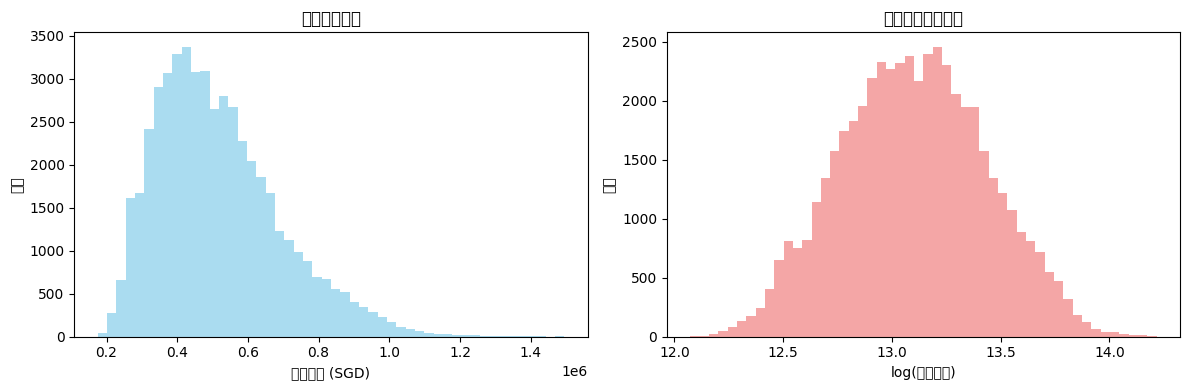

In [ ]:
# Check and visualize predictions (adapts to existing results)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If previous cell wasn't run, try minimal rebuild
if 'predictions' not in globals() or 'X_test' not in globals():
    print('[Note] predictions/X_test not found; trying to generate with trained model …')
    if 'final_rf' in globals() and 'X_test' in globals():
        predictions = final_rf.predict(X_test)
    else:
        raise RuntimeError('predictions not found and missing final_rf or X_test; please run the previous cell first.')

submission = pd.DataFrame({'id': range(len(predictions)), 'Predicted': predictions})
print(f"Num predictions: {len(predictions)}")
print(f"Predicted price range: {predictions.min():.0f} - {predictions.max():.0f}")

print(f"\nPrediction summary:")
print(f"Mean predicted price: {predictions.mean():.0f} SGD")
print(f"Median predicted price: {np.median(predictions):.0f} SGD")
print(f"Std of predicted price: {predictions.std():.0f} SGD")

print(f"\nFirst 10 predictions:")
print(submission.head(10))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(predictions, bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Price Distribution')
plt.xlabel('Predicted Price (SGD)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log(predictions), bins=50, alpha=0.7, color='lightcoral')
plt.title('Log Predicted Price Distribution')
plt.xlabel('log(Predicted Price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
# Validate encoding rules (self-contained; rebuilds variables if missing)
print("=== Encoding Rules Validation ===")

# If pre_df_geo or df_test is missing, try minimal rebuild
if 'pre_df_geo' not in globals() or 'df_test' not in globals():
    print('[Note] pre_df_geo or df_test not found; attempting minimal rebuild …')
    import pandas as pd
    from util.preprocess import preprocess as test_preprocess
    if 'df_test' not in globals():
        df_test = pd.read_csv('../data/test.csv')
    if 'geo' not in globals():
        import util.geo_data as geo
        from importlib import reload
        reload(geo)
    pre_df = test_preprocess(df_test)
    # If geo features missing, fill with zeros and align
    pre_df_geo = geo.add_geo_data(pre_df[['TOWN','BLOCK','STREET','FLOOR_AREA_SQM','LEASE_COMMENCE_DATA','RESALE_YEAR','RESALE_MONTH','FLOOR_AVG','FLAT_TYPE']].copy())
    required_geo_cols = [
        'DIST_TO_NEAREST_MRT_M', 'DIST_TO_NEAREST_HAWKER_M', 'DIST_TO_NEAREST_SHOP_M',
        'DIST_TO_NEAREST_PRIMARY_SCHOOL_M', 'DIST_TO_NEAREST_SECONDARY_SCHOOL_M',
        'NUM_PRIMARY_SCHOOLS_500M', 'NUM_PRIMARY_SCHOOLS_1000M',
        'NUM_SECONDARY_SCHOOLS_500M', 'NUM_SECONDARY_SCHOOLS_1000M'
    ]
    for c in required_geo_cols:
        if c not in pre_df_geo.columns:
            pre_df_geo[c] = 0.0
    pre_df_geo['YEAR'] = pre_df_geo['RESALE_YEAR']
    pre_df_geo['MONTH'] = pre_df_geo['RESALE_MONTH']
    pre_df_geo['AGE'] = pre_df_geo['YEAR'] - pre_df_geo['LEASE_COMMENCE_DATA']
    if 'town_mapping' not in globals():
        town_mapping = {
            'ang mo kio': 1, 'bedok': 2, 'bishan': 3, 'bukit batok': 4, 'bukit merah': 5,
            'bukit panjang': 6, 'bukit timah': 7, 'central area': 8, 'choa chu kang': 9,
            'clementi': 10, 'geylang': 11, 'hougang': 12, 'jurong east': 13, 'jurong west': 14,
            'kallang/whampoa': 15, 'marine parade': 16, 'pasir ris': 17, 'punggol': 18,
            'queenstown': 19, 'sembawang': 20, 'sengkang': 21, 'serangoon': 22,
            'tampines': 23, 'toa payoh': 24, 'woodlands': 25, 'yishun': 26
        }
    def encode_flat_type(flat_type: str) -> int:
        s = flat_type.lower().strip()
        if '1 room' in s or '1-room' in s:
            return 1
        if '2 room' in s or '2-room' in s:
            return 2
        if '3 room' in s or '3-room' in s:
            return 3
        if '4 room' in s or '4-room' in s:
            return 4
        if '5 room' in s or '5-room' in s:
            return 5
        if 'executive' in s:
            return 10
        if 'multi generation' in s:
            return 11
        return 3
    pre_df_geo['TOWN_ENCODED'] = pre_df_geo['TOWN'].str.lower().map(town_mapping)
    pre_df_geo['FLAT_TYPE_ENCODED'] = pre_df_geo['FLAT_TYPE'].apply(encode_flat_type)

# Continue validation
df_test_processed = pre_df_geo.copy()

print("TOWN encoding distribution:")
print(df_test_processed['TOWN_ENCODED'].value_counts().sort_index())

print("\nFLAT_TYPE encoding distribution:")
print(df_test_processed['FLAT_TYPE_ENCODED'].value_counts().sort_index())

if 'FLAT_MODEL_ENCODED' in df_test_processed.columns:
    print("\nFLAT_MODEL encoding distribution:")
    print(df_test_processed['FLAT_MODEL_ENCODED'].value_counts().sort_index())
else:
    print("\nNote: This pipeline did not produce FLAT_MODEL_ENCODED; skipped its distribution.")

print("\nUnencoded values check:")
print(f"TOWN unencoded count: {int(df_test_processed['TOWN_ENCODED'].isnull().sum())}")
print(f"FLAT_TYPE unencoded count: {int(df_test_processed['FLAT_TYPE_ENCODED'].isnull().sum())}")
if 'FLAT_MODEL_ENCODED' in df_test_processed.columns:
    print(f"FLAT_MODEL unencoded count: {int(df_test_processed['FLAT_MODEL_ENCODED'].isnull().sum())}")

print("\nRaw test data samples:")
if 'df_test' in globals():
    cols_show = [c for c in ['TOWN','FLAT_TYPE','FLAT_MODEL'] if c in df_test.columns]
    print(df_test[cols_show].head(10))

print("\nEncoded test data samples:")
cols_to_show = [c for c in ['TOWN_ENCODED', 'FLAT_TYPE_ENCODED', 'FLAT_MODEL_ENCODED'] if c in df_test_processed.columns]
print(df_test_processed[cols_to_show].head(10))


=== 编码规则验证 ===
TOWN编码分布:
TOWN_ENCODED
1     2075
2     2635
3      864
4     2011
5     1947
6     1765
7      118
8      381
9     2253
10    1115
11    1222
12    2600
13     974
14    3293
15    1508
16     305
17    1398
18    3637
19    1390
20    1509
21    4132
22     911
23    3435
24    1588
25    3586
26    3348
Name: count, dtype: int64

FLAT_TYPE编码分布:
FLAT_TYPE_ENCODED
1        21
2      1002
3     11992
4     21126
5     12232
10     3611
11       16
Name: count, dtype: int64

提示: 本流程未生成 FLAT_MODEL_ENCODED 列，已跳过其分布统计。

未编码值检查:
TOWN未编码数量: 0
FLAT_TYPE未编码数量: 0

原始测试数据样本:
            TOWN FLAT_TYPE  FLAT_MODEL
0      sembawang    3 room     model a
1    bukit merah    4 room     model a
2         bishan    3 room    improved
3        hougang    4 room  simplified
4  bukit panjang    4 room     model a
5        punggol    5-room    improved
6    jurong west    4 room     model a
7    jurong west    5 room    improved
8      woodlands    4 room     model a
9         yishun    4-

## 9. Model Summary


In [ ]:
print("=== Random Forest Summary ===")

# Cross-validation metrics: prefer metrics from CV cell; otherwise compute quickly
cv_rmse = cv_mae = cv_r2 = None
try:
    if 'cv_out' in globals():
        rmse_vals = -cv_out.get('test_rmse', [])
        mae_vals  = -cv_out.get('test_mae', [])
        r2_vals   =  cv_out.get('test_r2', [])
        import numpy as np
        if len(rmse_vals) and len(mae_vals) and len(r2_vals):
            cv_rmse = float(np.mean(rmse_vals))
            cv_mae  = float(np.mean(mae_vals))
            cv_r2   = float(np.mean(r2_vals))
except Exception:
    pass

if cv_rmse is None or cv_mae is None or cv_r2 is None:
    print('[Note] CV results not found; quickly running a 5-fold CV with best params …')
    from sklearn.model_selection import cross_validate
    from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor
    import numpy as np
    # Ensure X, y exist
    if 'X' not in globals() or 'y' not in globals():
        raise RuntimeError('Missing X or y; please run the CV or data preparation cells first.')
    best_params_for_cv = {
        'bootstrap': True,
        'max_depth': 49,
        'max_features': 'log2',
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 958,
    }
    tmp_rf = SKRandomForestRegressor(**best_params_for_cv, random_state=42, n_jobs=-1)
    scoring = {
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2' : 'r2',
    }
    tmp_cv = cross_validate(tmp_rf, X, y, cv=5, scoring=scoring, n_jobs=4, pre_dispatch='2*n_jobs')
    cv_rmse = float((-tmp_cv['test_rmse']).mean())
    cv_mae  = float((-tmp_cv['test_mae']).mean())
    cv_r2   = float((tmp_cv['test_r2']).mean())

print(f"CV RMSE: {cv_rmse:.2f}")
print(f"CV MAE: {cv_mae:.2f}")
print(f"CV R²: {cv_r2:.4f}")

# Feature importance: use existing if available; otherwise compute from final model
if 'feature_importance' not in globals():
    if 'final_rf' in globals():
        import pandas as pd
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': final_rf.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        feature_importance = None

print(f"\nTop 5 features:")
if feature_importance is not None:
    for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
        print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")
else:
    print('Unable to get feature importance (missing trained model).')


=== 随机森林模型总结 ===
交叉验证RMSE: 30738.62
交叉验证MAE: 21352.07
交叉验证R²: 0.9719

最重要的5个特征:
1. FLOOR_AREA_SQM: 0.2242
2. FLAT_TYPE_ENCODED: 0.1618
3. YEAR: 0.1446
4. DIST_TO_NEAREST_HAWKER_M: 0.0902
5. LEASE_COMMENCE_DATA: 0.0883
